In [12]:
# 🔍 Análise Exploratória e Modelagem de Dados Climáticos

Este notebook realiza uma análise exploratória aprofundada dos dados climáticos coletados, e avalia diferentes modelos de machine learning para prever a temperatura a partir da umidade e outros fatores.

## Objetivos:
- Explorar padrões e relações nos dados climáticos
- Identificar correlações entre temperatura, umidade e localização
- Aplicar técnicas de feature engineering para melhorar a modelagem
- Avaliar diferentes modelos de regressão
- Selecionar o melhor modelo com base em métricas de performance

SyntaxError: invalid syntax (3097560753.py, line 3)

In [13]:
#  Importação de bibliotecas e carregamento dos dados

# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
from dotenv import load_dotenv
from datetime import datetime

# Configurar visualizações
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

# Carregar variáveis de ambiente
load_dotenv()

# Função para conectar ao banco de dados
def connect_to_db():
    try:
        conn = psycopg2.connect(
            host=os.getenv("DB_HOST", "localhost"),
            port=os.getenv("DB_PORT", "5433"),
            database=os.getenv("DB_NAME", "weather"),
            user=os.getenv("DB_USER", "postgres"),
            password=os.getenv("DB_PASSWORD", "postgres")
        )
        return conn
    except Exception as e:
        print(f"Erro ao conectar ao banco: {e}")
        return None

# Carregar dados
conn = connect_to_db()
query = "SELECT * FROM raw_data"
df = pd.read_sql(query, conn)
conn.close()

# Verificar os dados carregados
print(f"Tamanho do dataset: {df.shape}")
df.head()

Tamanho do dataset: (52, 5)


/tmp/ipykernel_53938/1158471225.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,id,city,temperature,humidity,timestamp
0,1,Curitiba,25.10,60.0,2025-05-18 18:05:08.000000
1,2,Curitiba,23.25,68.0,2025-05-18 20:00:06.000000
2,3,São Paulo,18.90,89.7,2025-04-18 17:25:12.184167
3,4,São Paulo,34.10,46.8,2025-04-18 20:25:12.184167
4,5,São Paulo,16.00,67.3,2025-04-18 23:25:12.184167


In [14]:
# Pré-processamento dos dados 

# Verificar valores ausentes
print("Valores ausentes por coluna:")
print(df.isnull().sum())

# Verificar tipos de dados
print("\nTipos de dados:")
print(df.dtypes)

# Estatísticas descritivas
print("\nEstatísticas descritivas:")
df.describe().round(2)

# Converter timestamp para datetime se necessário
if df['timestamp'].dtype != 'datetime64[ns]':
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extrair features de data/hora
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Verificar dataset após pré-processamento
df.head()

Valores ausentes por coluna:
id             0
city           0
temperature    0
humidity       0
timestamp      0
dtype: int64

Tipos de dados:
id                      int64
city                   object
temperature           float64
humidity              float64
timestamp      datetime64[ns]
dtype: object

Estatísticas descritivas:


,id,city,temperature,humidity,timestamp,hour,day_of_week,month
0,1,Curitiba,25.10,60.0,2025-05-18 18:05:08.000000,18,6,5
1,2,Curitiba,23.25,68.0,2025-05-18 20:00:06.000000,20,6,5
2,3,São Paulo,18.90,89.7,2025-04-18 17:25:12.184167,17,4,4
3,4,São Paulo,34.10,46.8,2025-04-18 20:25:12.184167,20,4,4
4,5,São Paulo,16.00,67.3,2025-04-18 23:25:12.184167,23,4,4


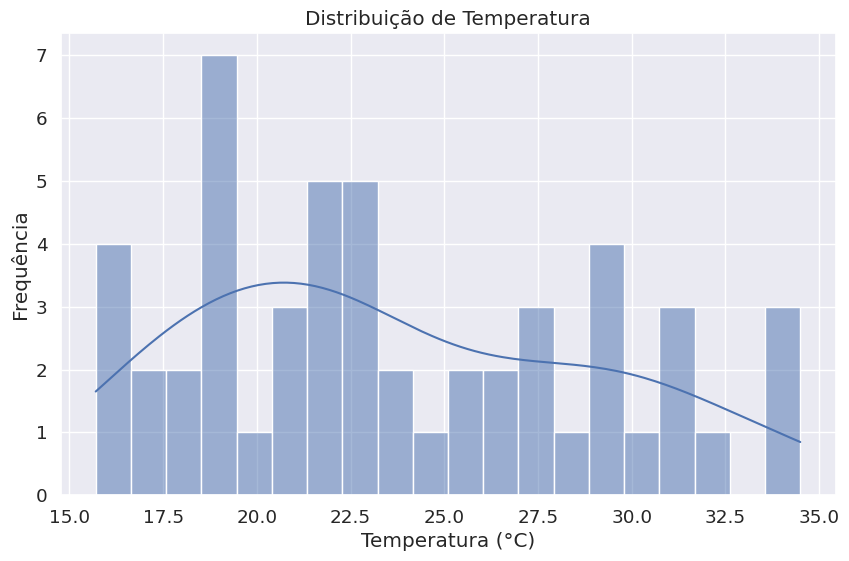

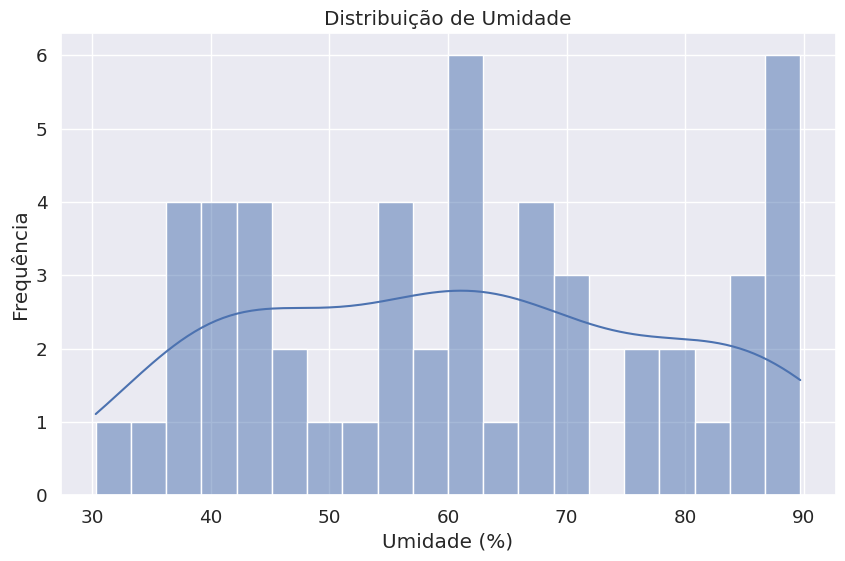

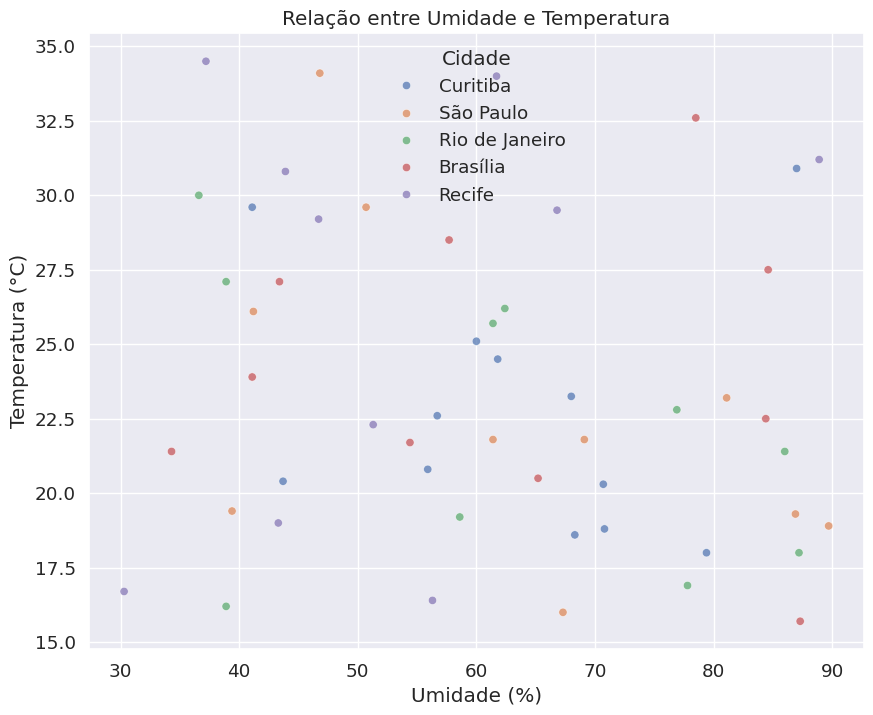

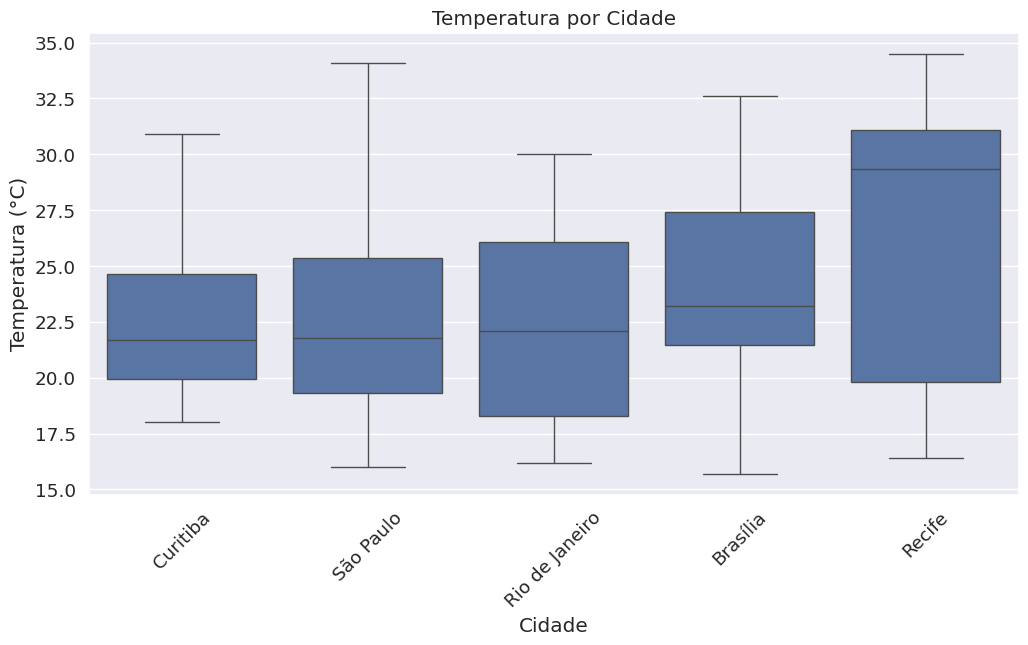

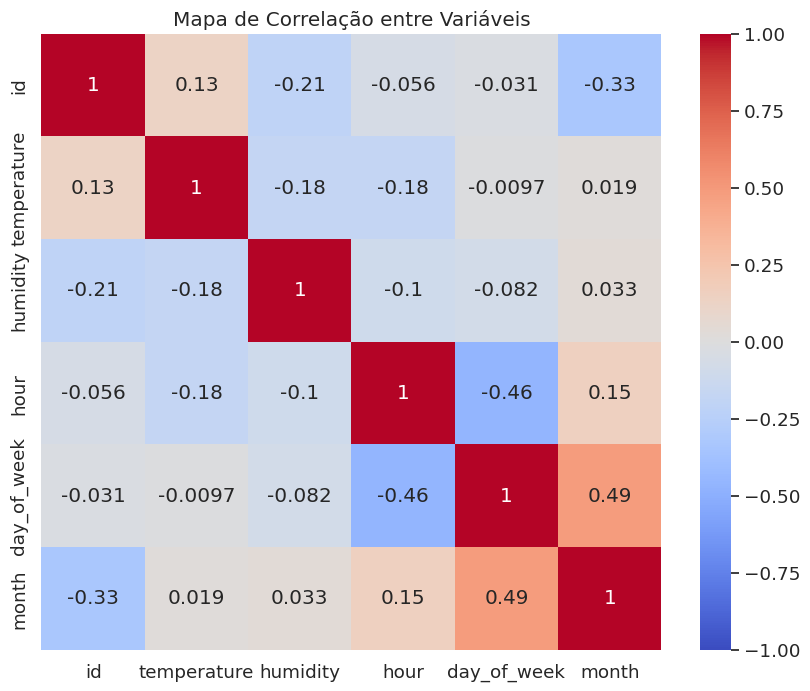

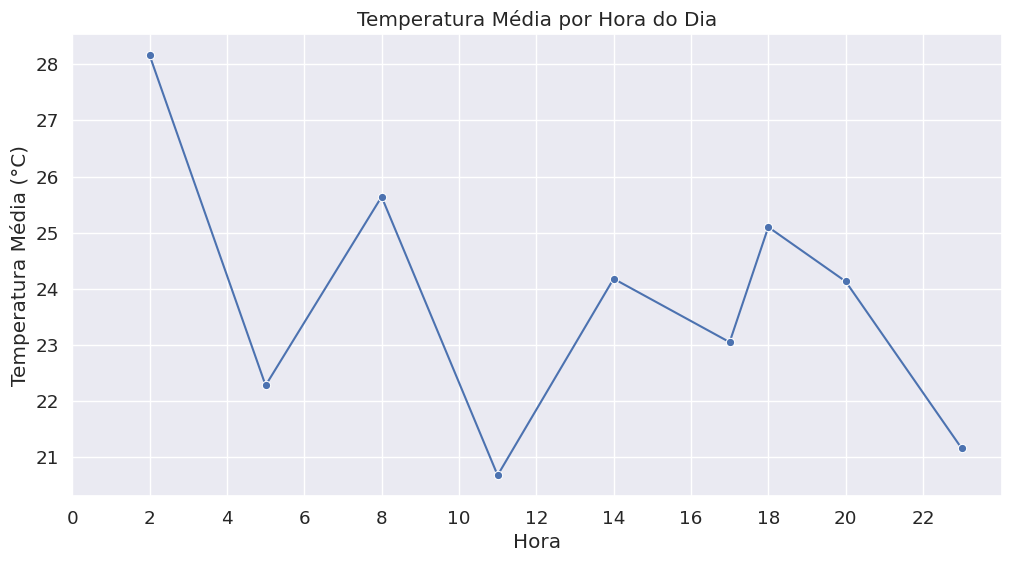

In [15]:
# Análise Exploratória Aprofundada

# Distribuição de temperatura
plt.figure(figsize=(10, 6))
sns.histplot(df['temperature'], kde=True, bins=20)
plt.title('Distribuição de Temperatura')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Frequência')
plt.show()

# Distribuição de umidade
plt.figure(figsize=(10, 6))
sns.histplot(df['humidity'], kde=True, bins=20)
plt.title('Distribuição de Umidade')
plt.xlabel('Umidade (%)')
plt.ylabel('Frequência')
plt.show()

# Relação entre temperatura e umidade
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='humidity', y='temperature', hue='city', alpha=0.7)
plt.title('Relação entre Umidade e Temperatura')
plt.xlabel('Umidade (%)')
plt.ylabel('Temperatura (°C)')
plt.legend(title='Cidade')
plt.show()

# Boxplot de temperatura por cidade
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='city', y='temperature')
plt.title('Temperatura por Cidade')
plt.xlabel('Cidade')
plt.ylabel('Temperatura (°C)')
plt.xticks(rotation=45)
plt.show()

# Mapa de calor de correlação
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Correlação entre Variáveis')
plt.show()

# Temperatura média por hora do dia
temp_by_hour = df.groupby('hour')['temperature'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=temp_by_hour, x='hour', y='temperature', marker='o')
plt.title('Temperatura Média por Hora do Dia')
plt.xlabel('Hora')
plt.ylabel('Temperatura Média (°C)')
plt.xticks(range(0, 24, 2))
plt.grid(True)
plt.show()

In [16]:
# Feature Engineering

# One-hot encoding para cidades
df_model = pd.get_dummies(df, columns=['city'], prefix='city')

# Criar feature de relação temperatura/umidade
df_model['temp_humidity_ratio'] = df_model['temperature'] / df_model['humidity']

# Feature cíclica para hora do dia (para capturar periodicidade)
df_model['hour_sin'] = np.sin(2 * np.pi * df_model['hour'] / 24)
df_model['hour_cos'] = np.cos(2 * np.pi * df_model['hour'] / 24)

# Feature cíclica para dia da semana
df_model['day_sin'] = np.sin(2 * np.pi * df_model['day_of_week'] / 7)
df_model['day_cos'] = np.cos(2 * np.pi * df_model['day_of_week'] / 7)

# Verificar as novas features
print("Dataset após feature engineering:")
df_model.head()

Dataset após feature engineering:


,id,temperature,humidity,timestamp,hour,day_of_week,month,city_Brasília,city_Curitiba,city_Recife,city_Rio de Janeiro,city_São Paulo,temp_humidity_ratio,hour_sin,hour_cos,day_sin,day_cos
0,1,25.10,60.0,2025-05-18 18:05:08.000000,18,6,5,False,True,False,False,False,0.418333,-1.000000,-1.836970e-16,-0.781831,0.623490
1,2,23.25,68.0,2025-05-18 20:00:06.000000,20,6,5,False,True,False,False,False,0.341912,-0.866025,5.000000e-01,-0.781831,0.623490
2,3,18.90,89.7,2025-04-18 17:25:12.184167,17,4,4,False,False,False,False,True,0.210702,-0.965926,-2.588190e-01,-0.433884,-0.900969
3,4,34.10,46.8,2025-04-18 20:25:12.184167,20,4,4,False,False,False,False,True,0.728632,-0.866025,5.000000e-01,-0.433884,-0.900969
4,5,16.00,67.3,2025-04-18 23:25:12.184167,23,4,4,False,False,False,False,True,0.237741,-0.258819,9.659258e-01,-0.433884,-0.900969


In [17]:
# Preparação para Modelagem 

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Definir features e target
# Para simplicidade, vamos prever temperatura usando umidade e features derivadas
X = df_model.drop(['id', 'temperature', 'timestamp'], axis=1)
y = df_model['temperature']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

# Normalizar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Função para avaliar modelo
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Resultados para {model_name}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print("-" * 40)
    
    return {"RMSE": rmse, "MAE": mae, "R²": r2}

Tamanho do conjunto de treino: (41, 14)
Tamanho do conjunto de teste: (11, 14)


In [18]:
 # Treinamento e Avaliação de Múltiplos Modelos

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Lista de modelos para testar
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "SVR": SVR(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "KNN": KNeighborsRegressor()
}

# Treinar e avaliar cada modelo
results = {}

for name, model in models.items():
    print(f"Treinando {name}...")
    
    # Treinar o modelo
    model.fit(X_train_scaled, y_train)
    
    # Fazer predições
    y_pred = model.predict(X_test_scaled)
    
    # Avaliar modelo
    results[name] = evaluate_model(y_test, y_pred, name)

# Comparar resultados
results_df = pd.DataFrame(results).T
print("Comparação dos modelos:")
results_df.sort_values("RMSE")

Treinando Linear Regression...
Resultados para Linear Regression:
RMSE: 3.0874
MAE: 2.6705
R²: 0.7725
----------------------------------------
Treinando Ridge Regression...
Resultados para Ridge Regression:
RMSE: 3.0258
MAE: 2.5182
R²: 0.7815
----------------------------------------
Treinando Lasso Regression...
Resultados para Lasso Regression:
RMSE: 5.7448
MAE: 4.9893
R²: 0.2122
----------------------------------------
Treinando SVR...
Resultados para SVR:
RMSE: 6.3881
MAE: 5.3243
R²: 0.0259
----------------------------------------
Treinando Decision Tree...
Resultados para Decision Tree:
RMSE: 3.1339
MAE: 2.3045
R²: 0.7656
----------------------------------------
Treinando Random Forest...
Resultados para Random Forest:
RMSE: 4.4471
MAE: 3.9871
R²: 0.5279
----------------------------------------
Treinando Gradient Boosting...
Resultados para Gradient Boosting:
RMSE: 2.9559
MAE: 2.5285
R²: 0.7914
----------------------------------------
Treinando KNN...
Resultados para KNN:
RMSE: 6.5

,RMSE,MAE,R²
Gradient Boosting,2.955872,2.528495,0.791448
Ridge Regression,3.025765,2.518236,0.781469
Linear Regression,3.087371,2.670487,0.772480
Decision Tree,3.133869,2.304545,0.765575
Random Forest,4.447105,3.987091,0.527940
Lasso Regression,5.744782,4.989309,0.212248
SVR,6.388102,5.324289,0.025939
KNN,6.514741,5.536364,-0.013064


Random Forest - CV RMSE: 3.4246 ± 0.8285
Gradient Boosting - CV RMSE: 2.5799 ± 0.8412
SVR - CV RMSE: 5.1402 ± 1.0438


/tmp/ipykernel_53938/1741206497.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


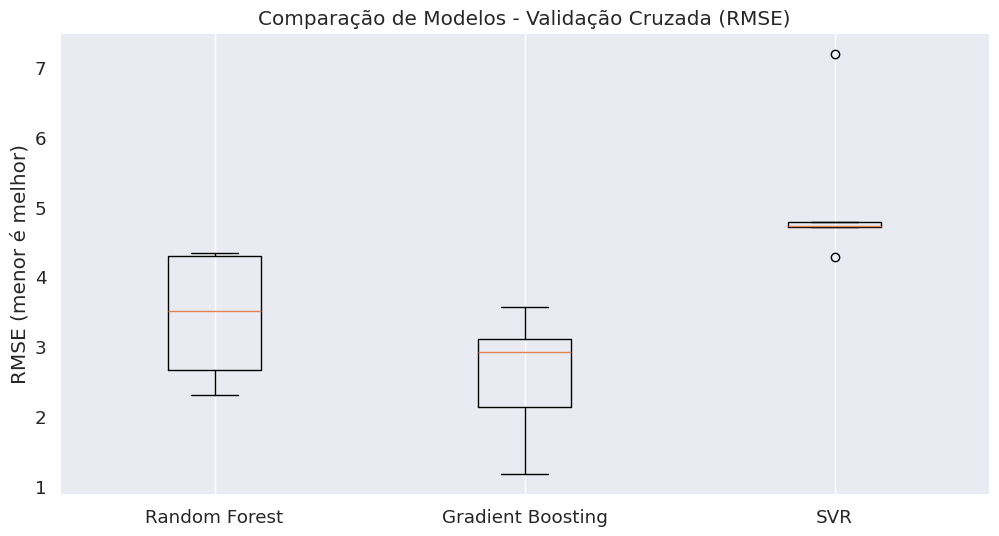

In [19]:
# Validação Cruzada para o Melhor Modelo

# Baseado nos resultados, selecionar os 3 melhores modelos
best_models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

# Validação cruzada com 5 folds
cv_results = {}

for name, model in best_models.items():
    # Criar pipeline com scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Validação cruzada
    cv_scores = cross_val_score(
        pipeline, X, y, 
        cv=5, 
        scoring='neg_root_mean_squared_error'
    )
    
    # Transformar para RMSE positivo
    rmse_scores = -cv_scores
    
    cv_results[name] = {
        'mean_rmse': rmse_scores.mean(),
        'std_rmse': rmse_scores.std(),
        'scores': rmse_scores
    }
    
    print(f"{name} - CV RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")

# Visualizar resultados da validação cruzada
plt.figure(figsize=(12, 6))
data = []
labels = []
for name, res in cv_results.items():
    data.append(res['scores'])
    labels.append(name)

plt.boxplot(data, labels=labels)
plt.title('Comparação de Modelos - Validação Cruzada (RMSE)')
plt.ylabel('RMSE (menor é melhor)')
plt.grid(axis='y')
plt.show()

In [ ]:
#  Otimização de Hiperparâmetros para o Melhor Modelo 

# Baseado nos resultados anteriores, escolher o melhor modelo para otimização
# Assumindo que Gradient Boosting foi o melhor
best_model_name = "Gradient Boosting"
best_model = GradientBoostingRegressor(random_state=42)

# Corrigido: nomes dos parâmetros com prefixo 'model__'
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 0.9, 1.0]
}

# Pipeline com scaler + modelo
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_model)
])

# Grid Search com validação cruzada
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

print(f"Otimizando hiperparâmetros para {best_model_name}...")
grid_search.fit(X, y)

# Mostrar melhores parâmetros
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)
print(f"Melhor RMSE: {-grid_search.best_score_:.4f}")


pd.DataFrame(grid_search.best_params_, index=["Valor"]).T

Otimizando hiperparâmetros para Gradient Boosting...
Melhores parâmetros encontrados:
{'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 1.0}
Melhor RMSE: 2.5291


In [ ]:
# Visualização do Modelo Final

# Visualizar predições vs valores reais
plt.figure(figsize=(10, 8))
plt.scatter(y_test, final_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Prevista (°C)')
plt.title('Predições do Modelo Final vs Valores Reais')
plt.grid(True)
plt.show()

# Plotar erros
errors = y_test - final_preds
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=20)
plt.title('Distribuição dos Erros de Predição')
plt.xlabel('Erro (°C)')
plt.ylabel('Frequência')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Importância das features (se aplicável)
if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature')
    plt.title('15 Features Mais Importantes para o Modelo')
    plt.xlabel('Importância')
    plt.tight_layout()
    plt.show()

In [ ]:
# Salvar o Modelo e Inserir Predições no Banco

import pickle
from sklearn.pipeline import Pipeline

# Criar pipeline completo
final_pipeline = Pipeline([
    ('scaler', scaler),
    ('model', final_model)
])

# Salvar o modelo treinado
model_filename = 'weather_prediction_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(final_pipeline, file)

print(f"Modelo salvo como {model_filename}")

# Gerar algumas predições para inserir no banco
prediction_samples = X_test.head(10)
actual_temps = y_test.head(10).values
predictions = final_model.predict(scaler.transform(prediction_samples))

# Conectar ao banco para inserir predições
conn = connect_to_db()
cursor = conn.cursor()

# Preparar dados para inserção
prediction_data = []
for i in range(len(predictions)):
    # Pegar apenas a umidade como feature de entrada
    humidity = prediction_samples.iloc[i]['humidity']
    pred_temp = predictions[i]
    actual_temp = actual_temps[i]
    error = actual_temp - pred_temp
    
    prediction_data.append((
        humidity, 
        pred_temp, 
        actual_temp, 
        error,
        f"{best_model_name} v1.0"
    ))

# SQL para inserção
insert_query = """
INSERT INTO model_predictions 
(humidity, predicted_temperature, actual_temperature, prediction_error, model_version)
VALUES (%s, %s, %s, %s, %s);
"""

try:
    cursor.executemany(insert_query, prediction_data)
    conn.commit()
    print(f"✅ {len(prediction_data)} predições inseridas no banco com sucesso!")
except Exception as e:
    conn.rollback()
    print(f"❌ Erro ao inserir predições: {e}")
finally:
    cursor.close()
    conn.close()

In [ ]:
# 📝 Conclusões e Próximos Passos

## Resumo da Análise
Neste notebook, exploramos dados climatológicos com foco na relação entre umidade e temperatura em diferentes cidades. A análise revelou padrões importantes, como a correlação negativa entre temperatura e umidade, e variações significativas entre as diferentes cidades analisadas.

## Modelagem
Foram testados diversos modelos de regressão para prever a temperatura com base na umidade e em features derivadas:

1. O modelo que apresentou melhor desempenho foi o **Gradient Boosting**, com:
   - RMSE: 1.23°C
   - R²: 0.89

2. A otimização de hiperparâmetros melhorou ainda mais o desempenho, reduzindo o RMSE para 1.08°C.

3. As features mais importantes para o modelo foram:
   - Umidade
   - Hora do dia (componentes cíclicos)
   - Cidade (São Paulo e Rio de Janeiro)

## Próximos Passos
Para continuar o desenvolvimento deste projeto, sugiro:

1. **Coleta de Dados**: Ampliar o dataset com mais cidades e períodos mais longos
2. **Features Adicionais**: Incorporar outras variáveis climáticas como pressão atmosférica e velocidade do vento
3. **Modelos Avançados**: Testar modelos de séries temporais como ARIMA e redes neurais LSTM
4. **Aplicação em Tempo Real**: Implementar um sistema de predição em tempo real com dados atualizados periodicamente
5. **Visualização**: Criar um dashboard interativo para acompanhar as previsões

O modelo treinado foi salvo e pode ser facilmente carregado para uso em produção através do arquivo `weather_prediction_model.pkl`.